In [13]:
# Import Library 

import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Functions Library

# Evaluating function using values from Coefficient array (Setting)
def eval_poly(x, coeffs):
    # coeffs[k] multiplies x^k
    powers = np.vstack([x**k for k in range(len(coeffs))])  # shape (K, N)
    return (coeffs[:, None] * powers).sum(axis=0)

# Formatting + Threshholding Condition
def format_poly(coeffs, var="x", thresh=1e-10):
    terms = []
    for k, c in enumerate(coeffs):
        if abs(c) < thresh:
            continue
        if k == 0:
            terms.append(f"{c:+.5g}")
        elif k == 1:
            terms.append(f"{c:+.5g}·{var}")
        else:
            terms.append(f"{c:+.5g}·{var}^{k}")
    return " ".join(terms) if terms else "0"
    

In [15]:
# Setting for the model

N = 200                    # number of samples
X_MIN, X_MAX = -1.0, 1.0   # sampling range for x
DEGREE = 10                # full polynomial library up to power DEGREE
NOISE_FRAC = 0.05          # noise level as fraction of std(y_true)
TRUE_COEFFS = np.array([3.0, 0.0, -3.0, 0.0, 0.0, 1.0]) # tested model

In [16]:
# generating coordinates 

x = np.linspace(X_MIN, X_MAX, N)
y_true = eval_poly(x, TRUE_COEFFS)

# Add Gaussian noise to y

y = y_true + NOISE_FRAC * np.std(y_true) * np.random.randn(N) #normaly distributed error

In [17]:
# Variables in Theta (Library)

Theta = np.vander(x, N=DEGREE+1, increasing=True) # shape (N, DEGREE+1)

In [18]:
# OLS to minimize error

w_hat, residuals, rank, s = np.linalg.lstsq(Theta, y, rcond=None)

In [19]:
# Computing y_hat = Theta(Library)*Xi(coefficients)_hat (since )

y_hat = Theta @ w_hat

In [20]:
# printing the discovered polynomial 

print("True polynomial:      y(x) =", format_poly(TRUE_COEFFS))
print("Estimated polynomial: y(x) =", format_poly(w_hat))

True polynomial:      y(x) = +3 -3·x^2 +1·x^5
Estimated polynomial: y(x) = +3.0029 +0.020497·x -3.1763·x^2 -0.30962·x^3 +1.5085·x^4 +1.8746·x^5 -4.7345·x^6 -0.80998·x^7 +5.9818·x^8 +0.22266·x^9 -2.5713·x^10


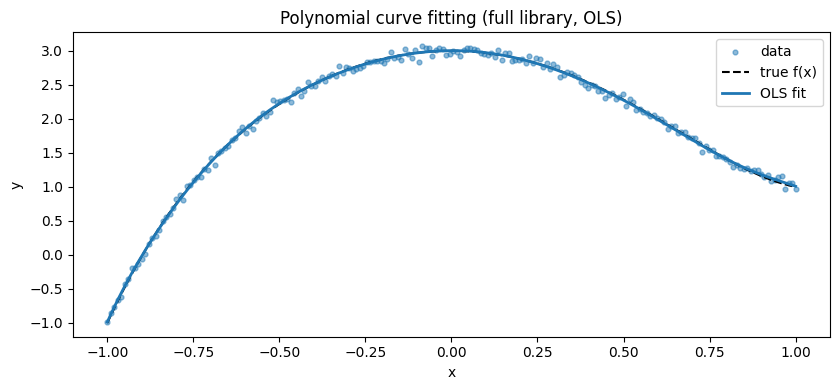

In [21]:
# OLS Results 
# Figure 1 - OLS fit curve 

plt.figure(figsize=(8.5, 4))
plt.scatter(x, y, s=12, alpha=0.5, label="data")
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_hat, label="OLS fit", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("OLS fitting")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# Ridge Regularization (L2)
lambda_ridge = 1e-3        #Tuning parameter 

# Ridge Regression (From derived w_MAP)

I = np.eye(Theta.shape[1])
w_ridge = np.linalg.solve(Theta.T @ Theta + lambda_ridge * I, Theta.T @ y)
y_ridge = Theta @ w_ridge

print("Ridge polynomial: y(x) =", format_poly(w_ridge))


Ridge polynomial: y(x) = +2.9944 -0.023193·x -2.9175·x^2 +0.12135·x^3 -0.29184·x^4 +0.70314·x^5 +0.22687·x^6 +0.37192·x^7 +0.14903·x^8 -0.16926·x^9 -0.13621·x^10


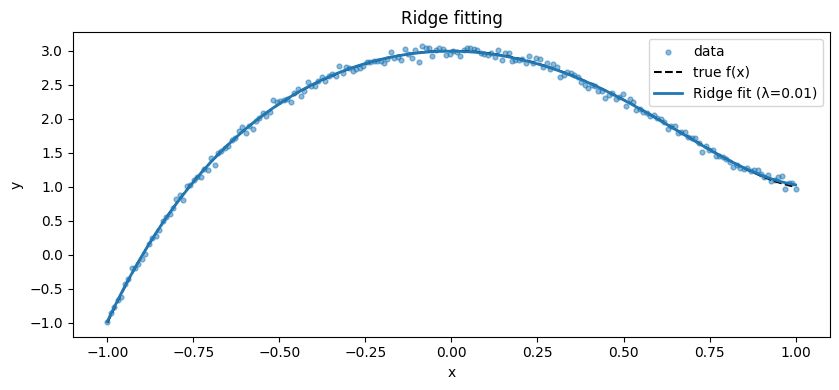

In [25]:
# Figure 2 - Ridge Regression Fit curve 

plt.figure(figsize=(8.5, 4))
plt.scatter(x, y, s=12, alpha=0.5, label="data")
plt.plot(x, y_true, "k--", label="true f(x)")
plt.plot(x, y_ridge, label=f"Ridge fit (λ={lambda_ridge})", linewidth=2)
plt.xlabel("x"); plt.ylabel("y")
plt.title("Ridge fitting")
plt.legend()
plt.tight_layout()
plt.show()


OLS   RMSE=8.1829e-03, MAE=6.2287e-03
Ridge RMSE=6.9185e-03, MAE=5.0236e-03


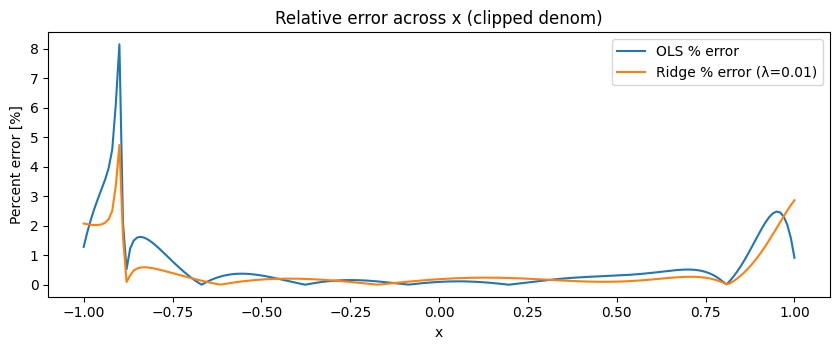

In [26]:
# Error comparison 

# RMSE, MAE comparison
def rmse(a, b): return np.sqrt(np.mean((a - b)**2))
def mae(a, b):  return np.mean(np.abs(a - b))

err_ols_rmse = rmse(y_hat, y_true)
err_ridge_rmse = rmse(y_ridge, y_true)
err_ols_mae = mae(y_hat, y_true)
err_ridge_mae = mae(y_ridge, y_true)

print(f"OLS   RMSE={err_ols_rmse:.4e}, MAE={err_ols_mae:.4e}")
print(f"Ridge RMSE={err_ridge_rmse:.4e}, MAE={err_ridge_mae:.4e}")

# percentage error comparison plot
eps = 0.05 * np.std(y_true)
denom = np.clip(np.abs(y_true), eps, None)
err_ols_pct   = 100 * np.abs(y_hat   - y_true) / denom
err_ridge_pct = 100 * np.abs(y_ridge - y_true) / denom

plt.figure(figsize=(8.5, 3.6))
plt.plot(x, err_ols_pct,   label="OLS % error")
plt.plot(x, err_ridge_pct, label=f"Ridge % error (λ={lambda_ridge})")
plt.xlabel("x"); plt.ylabel("Percent error [%]")
plt.title("Relative error across x (clipped denom)")
plt.legend()
plt.tight_layout()
plt.show()
